In [1]:
import time
import win32gui
import numpy as np

import mss
import mss.tools
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from cloningCNN import CloningCNN

from torch.distributions import Categorical

from pynput.keyboard import Key, Controller
import matplotlib.pyplot as plt

# Define RL environment for the game window

In [2]:
class GameEnv:
    def __init__(self, windowName, inputInterval):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        
        self.captureWindow = None
        self.prevGoldPixels = None
        self.prevLvlPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {0:Key.up, 1:Key.right, 2:Key.down, 3:Key.left}
        self.inputInterval = inputInterval
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
        
        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
    
    def quickRestart(self):
        for key in [Key.esc, Key.up, Key.up, Key.up, Key.right]:
            self.keyboard.press(key)
            self.keyboard.release(key)
            time.sleep(0.1)
        time.sleep(1)
    
    def reset(self):
        self.quickRestart()
        initScreen, initGoldPixels, initLvlPixels, heartPixels = self.getScreenInfo()
        self.prevGoldPixels = initGoldPixels
        self.prevLvlPixels = initLvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow = [initScreen for _ in range(4)]
        
        return self.captureWindow
    
    def getScreenInfo(self):
        # capture screen and downscale to 180x180
        self.capNum += 1
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
        padded = ImageOps.expand(img, (30,38,26,18))
        resized = padded.resize((360,360), self.downsamplingMethod)
        final = resized.resize((180,180), self.downsamplingMethod)
        
        # check screen for reward indicators
        goldPixels = np.array(final.crop((158,11,170,17))) == 255 # white pixels of gold meter in top right
        goldPixels = goldPixels.astype(int)
        
        lvlPixels = np.array(final.crop((170,170,180,180))) == 255
        lvlPixels = lvlPixels.astype(int)
        
        heartPixels = []
        for pixelCoord in [121,125,134,138]:
            heartPixels.append(np.array(final.crop((pixelCoord,12,pixelCoord+1,13))).sum())

        return (final, goldPixels, lvlPixels, heartPixels)
    
    def step(self, action):
        done = False
        reward = 0
        
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(self.inputInterval)
        screen, goldPixels, lvlPixels, heartPixels = self.getScreenInfo()
        
        # check if got reward
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0: # gold value changed
            reward += 10
        if np.sum(np.abs(lvlPixels - self.prevLvlPixels)) != 0: # beat level 1
            reward += 100
            done = True
            
        # check for damage or dead
        for heartIndex, heartPixel in enumerate(heartPixels):
            if self.prevHeartPixels[heartIndex] != 115 and heartPixel == 115:
                reward -= 10
        if heartPixels[0] == 115:
            done = True
            
        # update state variables
        self.prevGoldPixels = goldPixels
        self.prevLvlPixels = lvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow.pop()
        self.captureWindow.insert(0, screen)
        
        return (self.captureWindow, reward, done)

# Define Agent with CNN

In [3]:
class CloningAgent:
    def __init__(self, paramsFile, gamma=0.99):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print("using cuda")
        else:
            self.device = torch.device('cpu')
        self.cloningCNN = CloningCNN('deeper', dropout=0.5, inChannels=12)
        self.cloningCNN.load_state_dict(torch.load(paramsFile))
        self.cloningCNN.eval()
#         self.cloningCNN = self.cloningCNN.to(device=self.device)
        self.normTransform = self.getNormTransform()
        
        self.saved_log_probs = []
        self.rewards = []
        self.gamma = gamma
        
        self.eps = np.finfo(np.float32).eps.item()
        self.optimizer = optim.Adam(self.cloningCNN.parameters(), lr=1e-4)
        
    def getNormTransform(self):
        meanImage = np.load("data/stats/dsetMean.npy")
        stdImage = np.load("data/stats/dsetStd.npy")
        plt.subplot(121)
        plt.imshow(np.array(np.round(meanImage), dtype=np.uint8))
        plt.title("Mean image")
        plt.subplot(122)
        plt.imshow(np.array(np.round(stdImage), dtype=np.uint8))
        plt.title("Std image")
        # get channel means formatted like tensors
        channelMeans = meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
        channelStds = meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(channelMeans, channelStds)
        ])
        
    def getActionScores(self, state, verbose=False):
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in state]
        x = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
#         x = x.to(device=self.device, dtype=torch.float32)  # move to device, e.g. GPU
        actionScores = self.cloningCNN(x)   #.data.cpu().numpy()[0]
        if verbose:
            print(actionScores)
        return actionScores

    def sampleAction(self, state, verbose=False):
        scores = self.getActionScores(state, verbose)
        probs = F.softmax(scores, dim=1)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    def finishEpisode(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.saved_log_probs[:]

using cuda


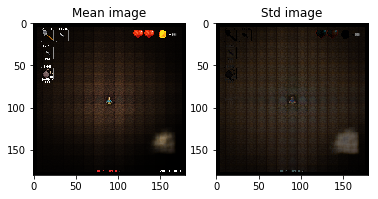

In [4]:
windowName = "Crypt of the NecroDancer"
env = GameEnv(windowName, 0.32)
agent = CloningAgent("models/cloningCNN_val77_05_31_T16_48.pt")

In [5]:
running_reward = 20
log_interval = 1
rewardsOverTime = []

In [6]:
print("Move the windows taskbar!")
time.sleep(4) # activate the game window during this
for i_episode in range(10000):
    state = env.reset()
    t, timeSinceReward, totalReward = 0, 0, 0
    while timeSinceReward < 250:  # Don't infinite loop while learning
        action = agent.sampleAction(state, verbose=(t%40==0))
        state, reward, done = env.step(action)
        if reward != 0:
            timeSinceReward = 0
            totalReward += reward
#             print("Got reward {}.".format(reward))
        agent.rewards.append(reward)
        aborted = win32gui.GetWindowText(win32gui.GetForegroundWindow()) != windowName
        if aborted or done:
            break
        timeSinceReward += 1
        t += 1
    if aborted:
        print("Game window no longer active. Stopping training.")
        break
    
    print('finishing episode...')
    running_reward = running_reward * 0.95 + t * 0.05
    agent.finishEpisode()
    rewardsOverTime.append(totalReward)
    
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i_episode, totalReward, running_reward))
    

Move the windows taskbar!
tensor([[-0.7908,  0.7257,  0.5183, -1.0708]])
tensor([[-0.3110,  1.1177, -0.6809, -0.0805]])
tensor([[ 0.1287, -5.6161,  3.5664, -3.1182]])
finishing episode...
Episode 0	Last reward:    40	Average reward: 23.35
tensor([[-0.4572,  0.3775, -0.0919, -0.2772]])
tensor([[ 1.3939, -1.5547, -0.9829,  0.0064]])
finishing episode...
Episode 1	Last reward:    10	Average reward: 25.73
tensor([[-0.6832,  0.0910, -0.0330, -0.0198]])
finishing episode...
Episode 2	Last reward:   -40	Average reward: 25.05
tensor([[-0.8392,  0.2430,  0.6525, -0.2934]])
tensor([[ 1.1055, -1.7644, -0.3017, -0.3423]])
tensor([[ 0.5493, -1.1799, -0.0401, -0.3724]])
tensor([[-0.8490, -0.6794,  1.5134, -2.2155]])
tensor([[ 0.8278, -2.2728,  0.2532, -0.2897]])
tensor([[-0.5920,  0.4309,  0.1006, -0.3665]])
tensor([[ 0.2385, -1.5097,  0.5313, -1.0655]])
tensor([[-0.8077,  0.6989,  0.5245, -1.2957]])
tensor([[ 1.2443,  0.1583, -1.4806, -1.3256]])
tensor([[-0.1044,  0.5883, -0.1192, -1.6101]])
tensor

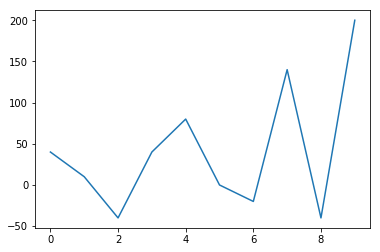

In [7]:
plt.plot(rewardsOverTime)
plt.show()

# Run the model greedily after training

In [ ]:
print("Move the windows taskbar!")
with torch.no_grad():
    time.sleep(4) # activate the game window during this
    state = env.reset()
    while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName: # exit on window unfocus
        actionScores = agent.getActionScores(state)
        print(actionScores)
        action = np.argmax(actionScores.data.numpy()[0])
        state, reward, done = env.step(action)
        if reward != 0:
            print("Got reward {}.".format(reward))
        
print("Game window no longer active. Exiting.")